In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# ***PREPROCESSING DATA***

In [179]:
url='https://drive.google.com/file/d/1KtFkqdY7osuZriR7twADKfC8ffy1jhCU/view?usp=drive_link'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
df= pd.read_csv(dwn_url)

df.shape

(754, 5)

In [180]:
df=df.drop(["Indicator","Unit"],axis=1)

In [181]:
df['Day'] = 1

In [182]:
month_dict = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April':4,
    'May':5,
    'June':6,
    'July':7,
    'August':8,
    'September':9,
    'October':10,
    'November':11,
    'December':12
}

df['Month'] = df['Month'].apply(lambda x: month_dict[x])

In [183]:
df['DATE'] = pd.to_datetime(df[['Year', 'Month','Day']])
df = df.sort_values(by='DATE')
df = df.drop(["Year","Month","Day"],axis=1)
df.columns = ["VALUE","DATE"]
df.set_index("DATE",inplace = True)


In [184]:
df_copy = df.copy()

In [185]:
df_copy

,VALUE
DATE,
1986-03-01,347.27
1986-04-01,349.20
1986-05-01,349.26
1986-06-01,348.96
1986-07-01,347.45
...,...
2048-08-01,454.06
2048-09-01,452.67
2048-10-01,452.66


In [186]:
df['VALUE'][df['VALUE'] > 690] = np.nan
df.isnull().sum().sum()

23

In [187]:
df['VALUE'] = df['VALUE'].interpolate(method='time')

In [188]:
def adfuller_test(value):
    result = adfuller(value)
    labels = ["ADF Test Statistic","p-value","#Lags Used","Number of Observations used"]
    for i,j in zip(result,labels):
        print(j+": "+str(i))
    
    if result[1]<=0.05:
        print("It is stationary")
    else:
        print("It is non-stationary")

In [189]:
adfuller_test(df["VALUE"])

ADF Test Statistic: 5.177830786318924
p-value: 1.0
#Lags Used: 20
Number of Observations used: 733
It is non-stationary


<Axes: xlabel='DATE'>

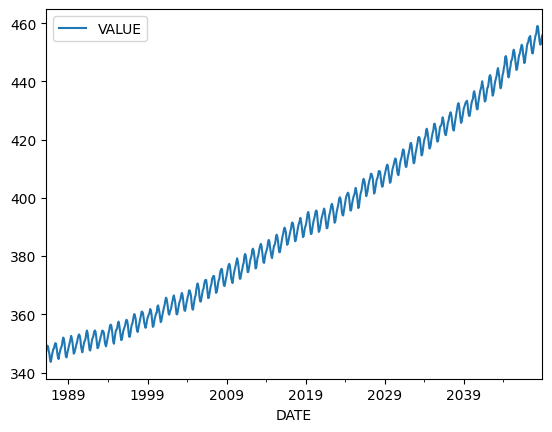

In [190]:
df.plot()

In [191]:
df["Value First Difference"]= df["VALUE"]-df["VALUE"].shift(1)

In [192]:
adfuller_test(df["Value First Difference"].dropna())

ADF Test Statistic: -5.0859768919628685
p-value: 1.4958348790712387e-05
#Lags Used: 20
Number of Observations used: 732
It is stationary


<Axes: xlabel='DATE'>

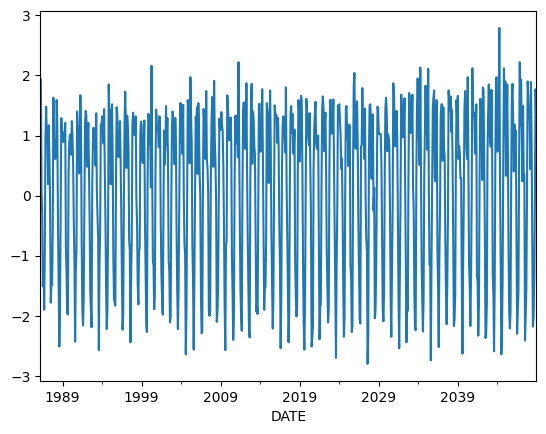

In [193]:
df["Value First Difference"].plot()

In [194]:
df.tail(10)

,VALUE,Value First Difference
DATE,,
2048-03-01,456.21,0.44
2048-04-01,458.10,1.89
2048-05-01,459.04,0.94
2048-06-01,458.26,-0.78
2048-07-01,456.08,-2.18
2048-08-01,454.06,-2.02
2048-09-01,452.67,-1.39
2048-10-01,452.66,-0.01
2048-11-01,454.43,1.77


<Axes: xlabel='DATE'>

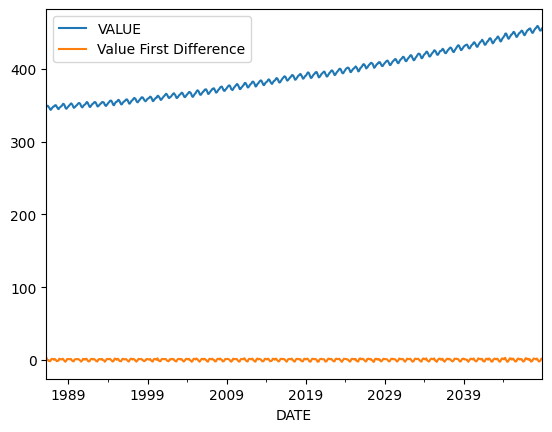

In [195]:
df.plot()

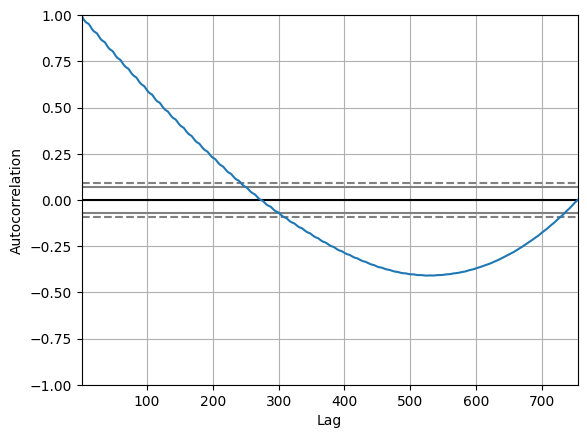

In [196]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df["VALUE"])
plt.show()

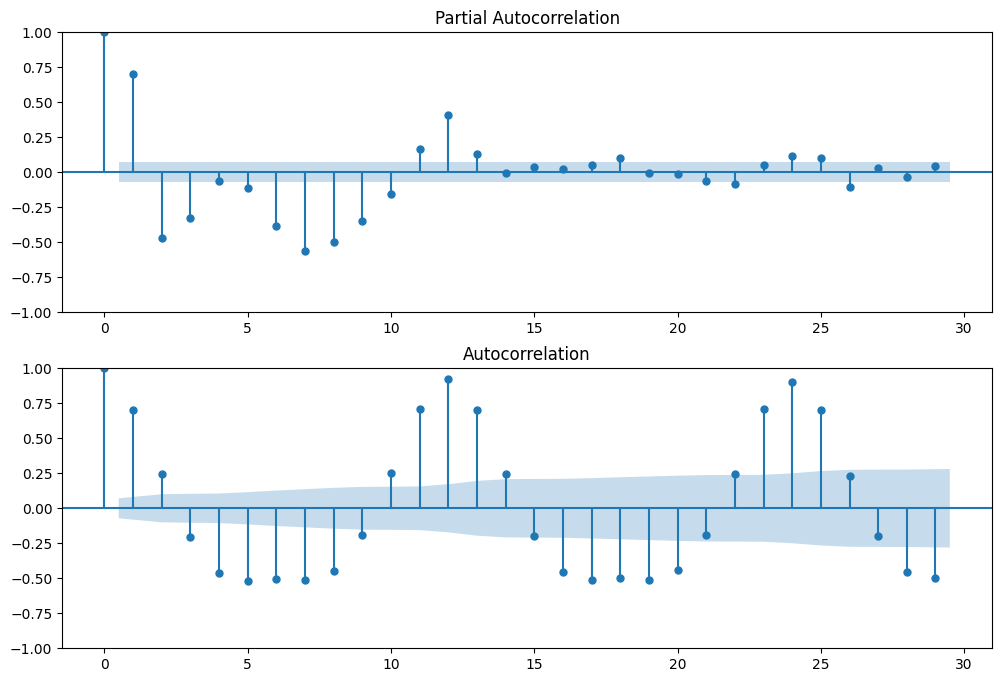

In [197]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(df["Value First Difference"].dropna(),ax=ax1)
ax2 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(df["Value First Difference"].dropna(),ax=ax2)

In [198]:
df

,VALUE,Value First Difference
DATE,,
1986-03-01,347.27,NaN
1986-04-01,349.20,1.93
1986-05-01,349.26,0.06
1986-06-01,348.96,-0.30
1986-07-01,347.45,-1.51
...,...,...
2048-08-01,454.06,-2.02
2048-09-01,452.67,-1.39
2048-10-01,452.66,-0.01


In [199]:
# models = [
#     SARIMAX(df['VALUE'],order=(1, 0, 1),seasonal_order =(1,0,1,12)),
#     SARIMAX(df['VALUE'],order=(1, 0, 2),seasonal_order =(1,0,2,12)),
#     SARIMAX(df['VALUE'],order=(2, 0, 2),seasonal_order =(2,0,2,12)),
#     SARIMAX(df['VALUE'],order=(1, 1, 2),seasonal_order =(1,1,2,12)),
#     SARIMAX(df['VALUE'],order=(2, 1, 1),seasonal_order =(2,1,1,12)),
#     SARIMAX(df['VALUE'],order=(2, 1, 2),seasonal_order =(2,1,2,12)),
   
# ]

# aic_value=[]
# bic_value=[]
# for model in models:
#     results = model.fit(disp=False)
#     aic_value.append(results.aic)
#     bic_value.append(results.bic)
    

# print("AIC values:")
# for value in aic_value:
#     print(value)


# print("BIC values:")
# for value in bic_value:
#     print(value)

In [200]:
def test_prediction_graph_generator_3(results,df):
    test_preds = results.predict(start=400,end=753)
    test_preds_df = pd.DataFrame(test_preds)
    test_preds_df.columns =["New_Forecast_df"]
    df["VALUE"].plot(figsize=(20,8))
    test_preds_df["New_Forecast_df"].plot(figsize=(20,8),color="red")
    actual_data = df["VALUE"][400:754]
    prediction_data = test_preds_df["New_Forecast_df"]
    mse = np.sqrt(np.mean((test_preds - actual_data)**2))
    plt.annotate("RMSE WHILE PREDICTING" + " " + str(mse), (0.33, 0.9), xycoords="axes fraction",fontsize = 14)
    plt.title("SARIMAX GRAPH FOR SHOWING (2,1,1) WITH REMOVED SPIKED DATA",fontsize=20,fontweight="bold")
    
   

In [201]:
def spike_removed_211(df):
    model = SARIMAX(df['VALUE'], order=(2,1,1), seasonal_order=(2,1,1,12))
    results = model.fit(disp=False)
    test_prediction_graph_generator_1(results,df)
    predictions = results.predict(start=df.index[-1], end=df.index[-1] + pd.DateOffset(months=24))
    pred_df = pd.DataFrame(predictions)
    pred_df.columns=["New_Forecast"]
    pred_df = pred_df.drop(pred_df.index[0])
    return model,predictions,pred_df

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


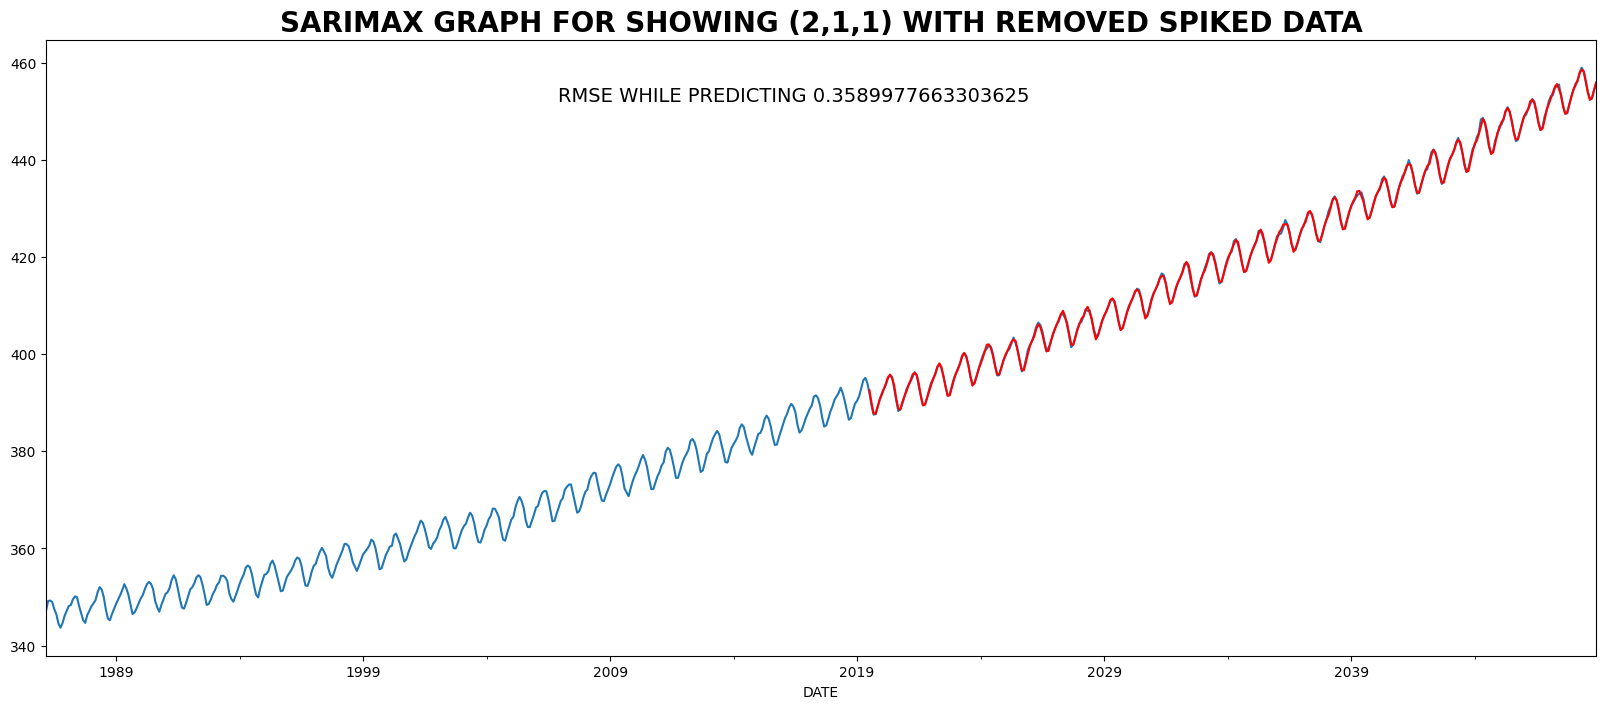

In [202]:
sarimax_model_3,predictions3,pred_df3 = spike_removed_211(df)

In [203]:
def test_prediction_graph_generator_1(results,df):
    test_preds = results.predict(start=400,end=753)
    test_preds_df = pd.DataFrame(test_preds)
    test_preds_df.columns =["New_Forecast_df"]
    df["VALUE"].plot(figsize=(20,8))
    test_preds_df["New_Forecast_df"].plot(figsize=(20,8),color="red")
    actual_data = df["VALUE"][400:754]
    prediction_data = test_preds_df["New_Forecast_df"]
    mse = np.sqrt(np.mean((test_preds - actual_data)**2))
    plt.annotate("RMSE WHILE PREDICTING" + " " + str(mse), (0.33, 0.9), xycoords="axes fraction",fontsize = 14)
    plt.title("SARIMAX GRAPH FOR SHOWING (1,1,2) WITH REMOVED SPIKED DATA",fontsize=20,fontweight="bold")
    
   

In [204]:
def spike_removed_112(df):
    model = SARIMAX(df['VALUE'], order=(1,1,2), seasonal_order=(1,1,2,12))
    results = model.fit(disp=False)
    test_prediction_graph_generator_1(results,df)
    predictions = results.predict(start=df.index[-1], end=df.index[-1] + pd.DateOffset(months=24))
    pred_df = pd.DataFrame(predictions)
    pred_df.columns=["New_Forecast"]
    pred_df = pred_df.drop(pred_df.index[0])
    return model,predictions,pred_df

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


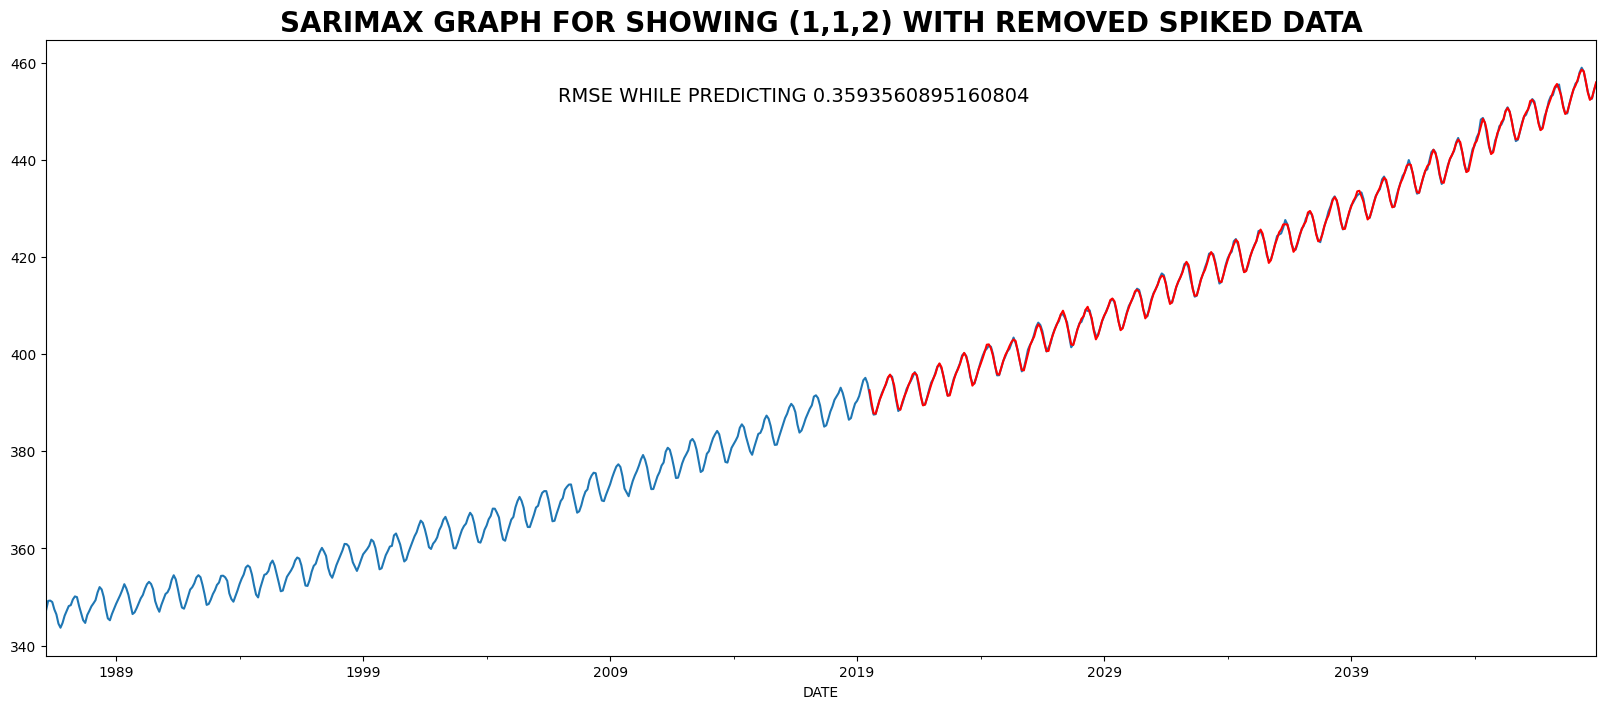

In [205]:
sarimax_model_1,predictions1,pred_df1 = spike_removed_112(df)



In [206]:
def test_prediction_graph_generator_2(results,df):
    test_preds = results.predict(start=400,end=753)
    test_preds_df = pd.DataFrame(test_preds)
    test_preds_df.columns =["New_Forecast_df"]
    df["VALUE"].plot(figsize=(20,8))
    test_preds_df["New_Forecast_df"].plot(figsize=(20,8),color="red")
    actual_data = df["VALUE"][400:754]
    prediction_data = test_preds_df["New_Forecast_df"]
    mse = np.sqrt(np.mean((test_preds - actual_data)**2))
    plt.annotate("RMSE WHILE PREDICTING" + " " + str(mse), (0.33, 0.9), xycoords="axes fraction",fontsize = 14)
    plt.title("SARIMAX GRAPH FOR SHOWING (2,1,2) WITH REMOVED SPIKED DATA",fontsize=20,fontweight="bold")

In [207]:
def spike_removed_202(df):
    model = SARIMAX(df['VALUE'], order=(2,1,2), seasonal_order=(2,1,2,12))
    results = model.fit(disp=False)
    test_prediction_graph_generator_2(results,df)
    predictions = results.predict(start=df.index[-1], end=df.index[-1] + pd.DateOffset(months=24))
    pred_df = pd.DataFrame(predictions)
    pred_df.columns=["New_Forecast"]
    pred_df = pred_df.drop(pred_df.index[0])
    return model,predictions,pred_df

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


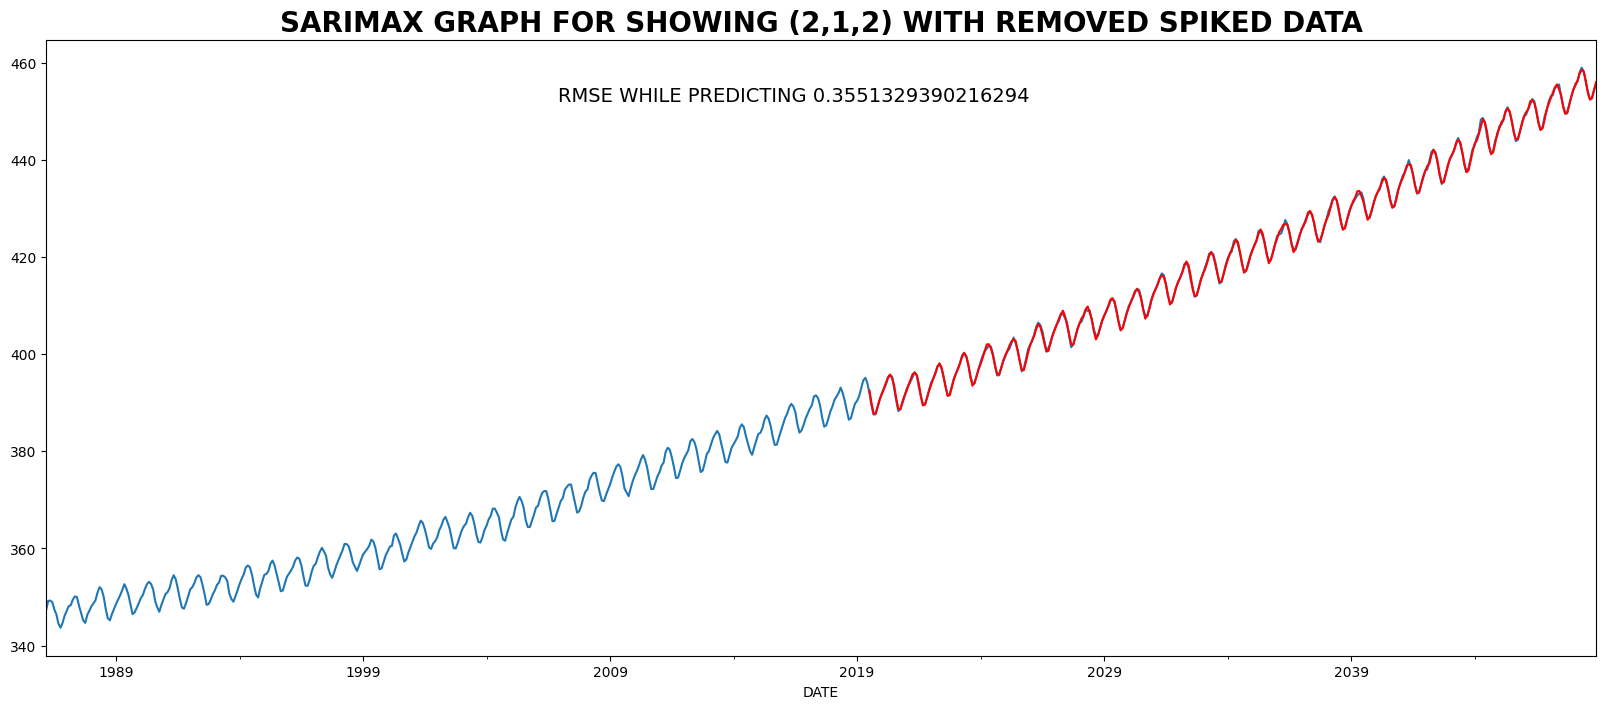

In [208]:
sarimax_model_2,predictions2,pred_df2 = spike_removed_202(df)


In [209]:
pred_df1


,New_Forecast
2049-01-01,457.184516
2049-02-01,458.126836
2049-03-01,458.966416
2049-04-01,460.576767
2049-05-01,461.298544
2049-06-01,460.613353
2049-07-01,458.621477
2049-08-01,456.425122
2049-09-01,454.870184
2049-10-01,455.110109


In [321]:
pred_df3

,New_Forecast
2049-01-01,457.180407
2049-02-01,458.103925
2049-03-01,458.970318
2049-04-01,460.592273
2049-05-01,461.325646
2049-06-01,460.604185
2049-07-01,458.621922
2049-08-01,456.414338
2049-09-01,454.856711
2049-10-01,455.113320


In [322]:
x = pred_df1.copy()
x['New_Forecast'] = pred_df1['New_Forecast']*.3 + pred_df3['New_Forecast']*0.7


In [323]:
x

,New_Forecast
2049-01-01,457.182461
2049-02-01,458.115380
2049-03-01,458.968367
2049-04-01,460.584520
2049-05-01,461.312095
2049-06-01,460.608769
2049-07-01,458.621700
2049-08-01,456.419730
2049-09-01,454.863448
2049-10-01,455.111715


In [324]:
x = x.reset_index()

In [325]:
x.columns = ["id","label"]
x["id"]= range(24)
x


,id,label
0,0,457.182461
1,1,458.115380
2,2,458.968367
3,3,460.584520
4,4,461.312095
5,5,460.608769
6,6,458.621700
7,7,456.419730
8,8,454.863448
9,9,455.111715


In [328]:
x

,id,label
0,0,457.182461
1,1,458.115380
2,2,458.968367
3,3,460.584520
4,4,461.312095
5,5,460.608769
6,6,458.621700
7,7,456.419730
8,8,454.863448
9,9,455.111715


In [329]:
x.to_csv("stacked_112_211.csv",index=False)

In [211]:
# op_df1 = pred_df1.copy()
# op_df2 = pred_df1.copy()
# op_df3 = pred_df1.copy()
# op_df4 = pred_df1.copy()
# op_df5 = pred_df1.copy()
# op_df6 = pred_df1.copy()
# op_df7 = pred_df1.copy()
# op_df8 = pred_df1.copy()
# op_df9=pred_df1.copy()

# op_df1["New_Forecast"] = pred_df1["New_Forecast"] * .5 + pred_df2["New_Forecast"]*.5
# op_df2["New_Forecast"] = pred_df1["New_Forecast"] * .6 + pred_df2["New_Forecast"]*.4
# op_df3["New_Forecast"] = pred_df1["New_Forecast"] * .4 + pred_df2["New_Forecast"]*.6
# op_df4["New_Forecast"] = pred_df1["New_Forecast"] * .3 + pred_df2["New_Forecast"]*.7
# op_df5["New_Forecast"] = pred_df1["New_Forecast"] * .7 + pred_df2["New_Forecast"]*.3
# op_df6["New_Forecast"] = pred_df1["New_Forecast"] * .8 + pred_df2["New_Forecast"]*.2
# op_df7["New_Forecast"] = pred_df1["New_Forecast"] * .2 + pred_df2["New_Forecast"]*.8
# op_df8["New_Forecast"] = pred_df1["New_Forecast"] * .9 + pred_df2["New_Forecast"]*.1
# op_df9["New_Forecast"] = pred_df1["New_Forecast"] * .1 + pred_df2["New_Forecast"]*.9



In [212]:
# op_ds1 = predictions1 * 0.5 + predictions2 * 0.5
# op_ds2 = predictions1 * 0.4 + predictions2 * 0.6
# op_ds3 = predictions1 * 0.6 + predictions2 * 0.4
# op_ds4 = predictions1 * 0.3 + predictions2 * 0.7
# op_ds5 = predictions1 * 0.7 + predictions2 * 0.3
# op_ds6 = predictions1 * 0.8 + predictions2 * 0.2
# op_ds7 = predictions1 * 0.2 + predictions2 * 0.8
# op_ds8 = predictions1 * 0.9 + predictions2 * 0.1
# op_ds9 = predictions1 * 0.1 + predictions2 * 0.9




In [279]:
testing_values1 = pred_df2.copy()
testing_values2 = pred_df2.copy()
testing_values3 = pred_df2.copy()


testing_values1["New_Forecast"] = [457.191134,
                   458.1005001,
                   458.9370318,
                   460.5350091,
                   461.2415177,
                   460.5581884,
                   458.5585123,
                   456.361485,
                   454.8032393,
                   455.0372497,
                   456.7946279,
                   458.2899483,
                   459.7079918,
                   460.60457,
                   461.4308319,
                   463.006438,
                   463.7051001,
                   463.0369196,
                   461.0575386,
                   458.8409207,
                   457.2782799,
                   457.5087648,
                   459.2630219,
                   460.7839698                   
]

testing_values2["New_Forecast"] = [457.1124919,
                   458.1104915,
                   458.9144304,
                   460.5261388,
                   461.2593019,
                   460.5619026,
                   458.5581366,
                   456.3660926,
                   454.8281092,
                   455.0300866,
                   456.790256,
                   458.2641565,
                   459.605179,
                   460.5977553,
                   461.394322,
                   462.9963295,
                   463.722873,
                   463.0350721,
                   461.0391471,
                   458.839087,
                   457.2968085,
                   457.498486,
                   459.2550271,
                   460.7430265                   
]

testing_values3["New_Forecast"] = [457.1936141,
                   458.1022403,
                   458.9459731,
                   460.5365923,
                   461.2509489,
                   460.5619026,
                   458.5581366,
                   456.3660926,
                   454.8281092,
                   455.0300866,
                   456.790256,
                   458.2641565,
                   459.605179,
                   460.5977553,
                   461.394322,
                   462.9963295,
                   463.722873,
                   463.0350721,
                   461.0391471,
                   458.839087,
                   457.2968085,
                   457.498486,
                   459.2550271,
                   460.7430265 
]



In [318]:
mse_1 = np.sqrt(np.mean((x['New_Forecast'] - testing_values1.squeeze())**2))
mse_1

0.10202068894325604

In [319]:
mse_2 = np.sqrt(np.mean((x['New_Forecast'] - testing_values2.squeeze())**2))
mse_2

0.115816024695441

In [320]:
mse_3 = np.sqrt(np.mean((x['New_Forecast'] - testing_values3.squeeze())**2))
mse_3

0.11451850203616679

In [214]:
# testing_values1.squeeze()

In [215]:
# mse11 = np.sqrt(np.mean((op_ds1 - testing_values1.squeeze())**2))
# mse12 = np.sqrt(np.mean((op_ds2 - testing_values1.squeeze())**2))
# mse13 = np.sqrt(np.mean((op_ds3 - testing_values1.squeeze())**2))
# mse14 = np.sqrt(np.mean((op_ds4 - testing_values1.squeeze())**2))
# mse15 = np.sqrt(np.mean((op_ds5 - testing_values1.squeeze())**2))
# mse16 = np.sqrt(np.mean((op_ds6 - testing_values1.squeeze())**2))
# mse17 = np.sqrt(np.mean((op_ds7 - testing_values1.squeeze())**2))
# mse18 = np.sqrt(np.mean((op_ds8 - testing_values1.squeeze())**2))
# mse19 = np.sqrt(np.mean((op_ds9 - testing_values1.squeeze())**2))

# print((mse11, mse12,mse13,mse14,mse15,mse16,mse17,mse18,mse19))

In [216]:
# mse21 = np.sqrt(np.mean((op_ds1 - testing_values2.squeeze())**2))
# mse22 = np.sqrt(np.mean((op_ds2 - testing_values2.squeeze())**2))
# mse23 = np.sqrt(np.mean((op_ds3 - testing_values2.squeeze())**2))
# mse24 = np.sqrt(np.mean((op_ds4 - testing_values2.squeeze())**2))
# mse25 = np.sqrt(np.mean((op_ds5 - testing_values2.squeeze())**2))
# mse26 = np.sqrt(np.mean((op_ds6 - testing_values2.squeeze())**2))
# mse27 = np.sqrt(np.mean((op_ds7 - testing_values2.squeeze())**2))
# mse28 = np.sqrt(np.mean((op_ds8 - testing_values2.squeeze())**2))
# mse29 = np.sqrt(np.mean((op_ds9 - testing_values2.squeeze())**2))

# print((mse21, mse22,mse23,mse24,mse25,mse26,mse27,mse28,mse29))

In [217]:
# mse31 = np.sqrt(np.mean((op_ds1 - testing_values3.squeeze())**2))
# mse32 = np.sqrt(np.mean((op_ds2 - testing_values3.squeeze())**2))
# mse33 = np.sqrt(np.mean((op_ds3 - testing_values3.squeeze())**2))
# mse34 = np.sqrt(np.mean((op_ds4 - testing_values3.squeeze())**2))
# mse35 = np.sqrt(np.mean((op_ds5 - testing_values3.squeeze())**2))
# mse36 = np.sqrt(np.mean((op_ds6 - testing_values3.squeeze())**2))
# mse37 = np.sqrt(np.mean((op_ds7 - testing_values3.squeeze())**2))
# mse38 = np.sqrt(np.mean((op_ds8 - testing_values3.squeeze())**2))
# mse39 = np.sqrt(np.mean((op_ds9 - testing_values3.squeeze())**2))

# print((mse31, mse32,mse33,mse34,mse35,mse36,mse37,mse38,mse39))

In [218]:
# op_df1

In [219]:
# op_df1 = op_df1.drop("index",axis=1)

In [220]:
# # op_df1 = op_df1.reset_index()
# op_df1.columns = ["id","label"]
# op_df1["id"] = range(24)

In [221]:
# op_df1

In [222]:
# op_df1.to_csv("stacked_op1.csv",index=False)

In [223]:
# op_df8 = op_df8.reset_index()

In [224]:
# op_df8.columns = ["id","label"]
# op_df8["id"]= range(24)
# op_df8

In [225]:
# op_df8.to_csv("stacked_op8.csv",index=False)

In [226]:
# url='https://drive.google.com/file/d/1KtFkqdY7osuZriR7twADKfC8ffy1jhCU/view?usp=drive_link'
# file_id=url.split('/')[-2]
# dwn_url='https://drive.google.com/uc?id=' + file_id
# df2= pd.read_csv(dwn_url)

# df2.shape

In [227]:
# df2=df2.drop(["Indicator","Unit"],axis=1)

In [228]:
# df2['Day'] = 1
# df2

In [229]:
# month_dict = {
#     'January': 1,
#     'February': 2,
#     'March': 3,
#     'April':4,
#     'May':5,
#     'June':6,
#     'July':7,
#     'August':8,
#     'September':9,
#     'October':10,
#     'November':11,
#     'December':12
# }

# df2['Month'] = df2['Month'].apply(lambda x: month_dict[x])
# df2

In [230]:
# df2['DATE'] = pd.to_datetime(df2[['Year', 'Month','Day']])

In [231]:
# df2

In [232]:
# df2 = df2.sort_values(by='DATE')

In [233]:
# df2 = df2.drop(["Year","Month","Day"],axis=1)

In [234]:
# df2.columns = ["VALUE","DATE"]

In [235]:
# df2

In [236]:
# df2.set_index("DATE",inplace = True)

In [237]:
# df2

In [238]:
# spikes = df2['VALUE'][df2['VALUE']>600]

# values_list = spikes.values

In [239]:
# values_list

In [240]:
# import statsmodels.tsa.stattools as ts
# from scipy.stats import boxcox
    

In [241]:
# transformed_values, lambda_value = boxcox(values_list)
# transformed_values

In [242]:
# df2["VALUE"] = transformed_values

In [243]:
# df2

In [244]:
# df2.plot()

In [245]:
# import math
# log_values = [math.(x) for x in values_list]
# log_values

In [246]:
# df2['VALUE'] = df2['VALUE'].interpolate(method='spline',order=2)

In [247]:
# df2.plot()

In [248]:
# models = [
#     SARIMAX(df2['VALUE'],order=(0, 0, 0),seasonal_order =(0,0,0,12)),
#     SARIMAX(df2['VALUE'],order=(0, 1, 0),seasonal_order =(0,1,0,12)),
#     SARIMAX(df2['VALUE'],order=(1, 0, 1),seasonal_order =(1,0,1,12)),
#     SARIMAX(df2['VALUE'],order=(2, 0, 1),seasonal_order =(2,0,1,12)),
#     SARIMAX(df2['VALUE'],order=(1, 0, 2),seasonal_order =(1,0,2,12)),
#     SARIMAX(df2['VALUE'],order=(2, 0, 2),seasonal_order =(2,0,2,12)),
#     SARIMAX(df2['VALUE'],order=(1, 1, 0),seasonal_order =(1,1,0,12)),
#     SARIMAX(df2['VALUE'],order=(2, 1, 1),seasonal_order =(2,1,1,12)),
#     SARIMAX(df2['VALUE'],order=(2, 1, 2),seasonal_order =(2,1,2,12)),
   
# ]

# aic_value=[]
# bic_value=[]
# for model in models:
#     results = model.fit(disp=False)
#     aic_value.append(results.aic)
#     bic_value.append(results.bic)
    

# print("AIC values:")
# for value in aic_value:
#     print(value)


# print("BIC values:")
# for value in bic_value:
#     print(value)

In [249]:
# def spike_unremoved_010(df):
#     model = SARIMAX(df['VALUE'], order=(0,1,0), seasonal_order=(0,1,0,12))
#     results = model.fit(disp=False)
#     test_prediction_graph_generator_2(results,df)
#     predictions = results.predict(start=df.index[-1], end=df.index[-1] + pd.DateOffset(months=24))
#     pred_df = pd.DataFrame(predictions)
#     pred_df.columns=["New_Forecast"]
#     pred_df = pred_df.drop(pred_df.index[0])
#     return model,predictions,pred_df

In [250]:
# sarimax_model_4,predictions4,pred_df4 = spike_unremoved_010(df2)